In the previous router, we invoked the model and, if it chose to call a tool, we returned a ToolMessage to the user.

- But, what if we simply pass that ToolMessage back to the model?

 - We can let it either (1) call another tool or (2) respond directly.

This is the intuition behind ReAct, a general agent architecture.

    act - let the model call specific tools
    observe - pass the tool output back to the model
    reason - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [2]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools=[add,multiply,divide]

llm=ChatOpenAI(model='gpt-4o')

llm_with_tools=llm.bind_tools(tools,parallel_tool_calls=False)

#### Defining State message

In [3]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated

class MessagesState(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

#### Alternate method -> can directly import using library instead of creating via class
from langgraph.graph import MessagesState

In [6]:
from langchain_core.messages import HumanMessage,SystemMessage

##System Message
sys_msg=SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [7]:
from langgraph.graph import START,StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image,display

#### Create a structure of Chatbot

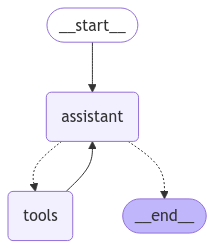

In [8]:
builder=StateGraph(MessagesState)

## Define the node
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))

## Define the edges
builder.add_edge(START,"assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools","assistant")

react_graph=builder.compile()   

#show
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [9]:
messages=[HumanMessage(content="Add 10 and 4. Multiply the output by 2. Divide the output ny 5")]
messages=react_graph.invoke({"messages":messages})

In [12]:
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 10 and 4. Multiply the output by 2. Divide the output ny 5
================================== Ai Message ==================================
Tool Calls:
  add (call_dDoQZQ7l3hmGfAKtKZQHKnUF)
 Call ID: call_dDoQZQ7l3hmGfAKtKZQHKnUF
  Args:
    a: 10
    b: 4
================================= Tool Message =================================
Name: add

14
================================== Ai Message ==================================
Tool Calls:
  multiply (call_saiWEQQLyrkgQFY9LORmDd2y)
 Call ID: call_saiWEQQLyrkgQFY9LORmDd2y
  Args:
    a: 14
    b: 2
================================= Tool Message =================================
Name: multiply

28
================================== Ai Message ==================================
Tool Calls:
  divide (call_3kLuhg6PcZOAcx8g79b3WFa5)
 Call ID: call_3kLuhg6PcZOAcx8g79b3WFa5
  Args:
    a: 28
    b: 5
================================= Tool Message ===========

#### Still we have one drawback which is chat history
- Here it won't store the chat history

In [13]:
messages=[HumanMessage(content="Add 10 to the result number")]
messages=react_graph.invoke({"messages":messages})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 10 to the result number
================================== Ai Message ==================================

Could you please provide the initial number you'd like me to add 10 to?


### Memory in Agents with Memory Saver

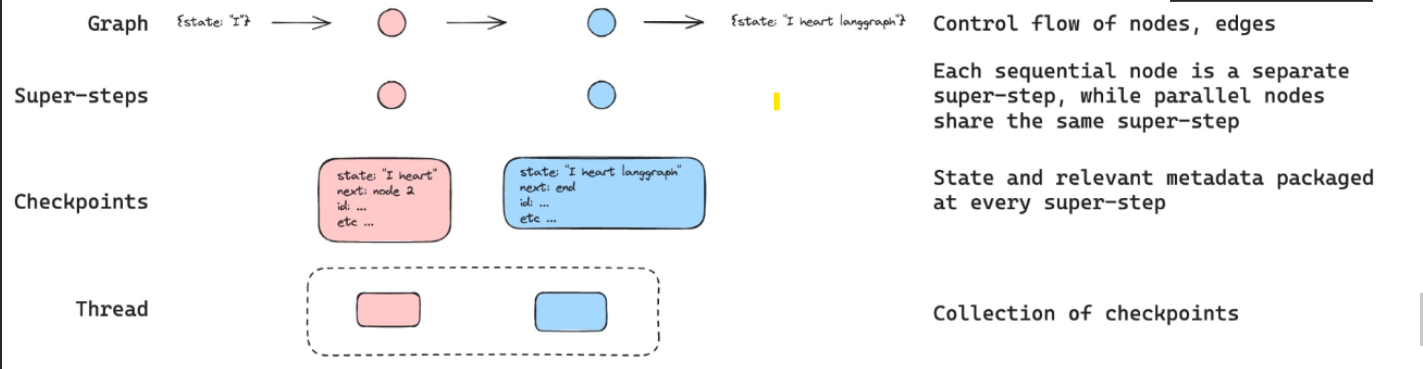

In [14]:
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()

react_graph=builder.compile(checkpointer=memory)

In [15]:
config={"configurable":{"thread_id":"1"}}

#Specify an input
messages=[HumanMessage(content="Add 4 and 4")]

#Run
messages=react_graph.invoke({"messages":messages},config)
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 4 and 4
================================== Ai Message ==================================
Tool Calls:
  add (call_pdgFmpLxd2E6dGEQJPrsvJcm)
 Call ID: call_pdgFmpLxd2E6dGEQJPrsvJcm
  Args:
    a: 4
    b: 4
================================= Tool Message =================================
Name: add

8
================================== Ai Message ==================================

The result of adding 4 and 4 is 8.


In [16]:
messages=[HumanMessage(content="Now add 5 to the result number")]
messages=react_graph.invoke({"messages":messages},config)
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 4 and 4
================================== Ai Message ==================================
Tool Calls:
  add (call_pdgFmpLxd2E6dGEQJPrsvJcm)
 Call ID: call_pdgFmpLxd2E6dGEQJPrsvJcm
  Args:
    a: 4
    b: 4
================================= Tool Message =================================
Name: add

8
================================== Ai Message ==================================

The result of adding 4 and 4 is 8.
================================ Human Message =================================

Now add 5 to the result number
================================== Ai Message ==================================
Tool Calls:
  add (call_aCnSDSmhI5S5YU5wcckVUwLU)
 Call ID: call_aCnSDSmhI5S5YU5wcckVUwLU
  Args:
    a: 8
    b: 5
================================= Tool Message =================================
Name: add

13
================================== Ai Message ==================================

The result 

### check with new user/thred

In [17]:
config2={"configurable":{"thread_id":"Bala"}}

messages=[HumanMessage(content="Now add 5 to the result number")]
messages=react_graph.invoke({"messages":messages},config2)
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Now add 5 to the result number
================================== Ai Message ==================================

Please provide the initial result number to which you want to add 5.
